In [3]:
import torch
import os
from dotenv import load_dotenv, find_dotenv
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
import pandas as pd
import time
import pinecone
from langchain_community.vectorstores import Pinecone
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
load_dotenv(find_dotenv())

True

In [6]:
embedding_model_name= "thenlper/gte-base"
faiss_index_path= "faiss_indices/"
search_type="similarity"
pinecone_index_name= "pubmed"
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
evaluation_data = pd.read_csv(f"../../data/questions_answers/questions_answers.csv")
evaluation_data.rename(columns={evaluation_data.columns[0]: 'PMID'}, inplace=True)
evaluation_data = evaluation_data[["PMID", "QUESTION"]]
evaluation_data.head()

,PMID,QUESTION
0,25752725,Schizophrenia patients with high intelligence:...
1,24232067,Do audiologic characteristics predict outcomes...
2,27286937,Do emotional intelligence and previous caring ...
3,24686463,Does brain volume loss predict cognitive and n...
4,26286897,Does emotional intelligence predict breaking b...


In [8]:
embedding_model = HuggingFaceEmbeddings(
    model_name = embedding_model_name,
    model_kwargs={'device': device},
    encode_kwargs={'normalize_embeddings': True}
)

In [9]:
faiss_vectorstore = FAISS.load_local(f"../../chatbot/faiss_indices/{embedding_model_name}", embedding_model)
pinecone_vectorstore = Pinecone(pinecone.Pinecone().Index(pinecone_index_name), embedding_model, "text")

In [11]:
retrievers_eval = dict()
for k in range(1, 6):
    faiss_retriever = faiss_vectorstore.as_retriever(search_type=search_type, search_kwargs={"k": k})
    pinecone_retriever = pinecone_vectorstore.as_retriever(search_type=search_type, search_kwargs={"k": k})
    for retriever in [faiss_retriever, pinecone_retriever]:
        elapsed_time = 0
        match_count = 0
        for gold_pmid, question in evaluation_data.values:
            start_time = time.time()
            retrieved_documents = retriever.get_relevant_documents(question)
            end_time = time.time()
            elapsed_time += end_time - start_time

            retrieved_pmids = [int(document.metadata['PMID']) for document in retrieved_documents]
            if gold_pmid in retrieved_pmids:
                match_count += 1

        # Collecting results for MD file generation
        if retriever.tags[0] not in retrievers_eval:
            retrievers_eval[retriever.tags[0]] = []
        retrievers_eval[retriever.tags[0]].append({
            'k': k,
            'execution_time_per_query': elapsed_time / evaluation_data.shape[0],
            'total_execution_time': elapsed_time,
            'match_count': match_count,
            'success_percentage': match_count / evaluation_data.shape[0]
        })
        print(f"k:{k}, Vectorstore: {retriever.tags[0]}, execution time per query: {(elapsed_time / evaluation_data.shape[0]):.4f}, execution time: {elapsed_time:.4f}, match count: {match_count}, success percentage: {(match_count / evaluation_data.shape[0]):.2f}")
    print("-------------------------------------------------------------------------------")

k:1, Vectorstore: FAISS, execution time per query: 0.0211, execution time: 3.5279, match count: 152, success percentage: 0.91
k:1, Vectorstore: Pinecone, execution time per query: 0.2124, execution time: 35.4665, match count: 152, success percentage: 0.91
-------------------------------------------------------------------------------
k:2, Vectorstore: FAISS, execution time per query: 0.0209, execution time: 3.4897, match count: 158, success percentage: 0.95
k:2, Vectorstore: Pinecone, execution time per query: 0.2247, execution time: 37.5285, match count: 159, success percentage: 0.95
-------------------------------------------------------------------------------
k:3, Vectorstore: FAISS, execution time per query: 0.0207, execution time: 3.4646, match count: 163, success percentage: 0.98
k:3, Vectorstore: Pinecone, execution time per query: 0.2227, execution time: 37.1911, match count: 162, success percentage: 0.97
------------------------------------------------------------------------

In [12]:
# Data for plotting
k_values = [1, 2, 3, 4, 5]
vectorstores = ['FAISS', 'Pinecone']
metrics = {
    'FAISS': {
        'execution_time_per_query': [item['execution_time_per_query'] for item in retrievers_eval['FAISS']],
        'total_execution_time': [item['total_execution_time'] for item in retrievers_eval['FAISS']],
        'success_percentage': [item['success_percentage']*100 for item in retrievers_eval['FAISS']],
    },
    'Pinecone': {
        'execution_time_per_query': [item['execution_time_per_query'] for item in retrievers_eval['Pinecone']],
        'total_execution_time': [item['total_execution_time'] for item in retrievers_eval['Pinecone']],
        'success_percentage': [item['success_percentage']*100 for item in retrievers_eval['Pinecone']],
    }
}

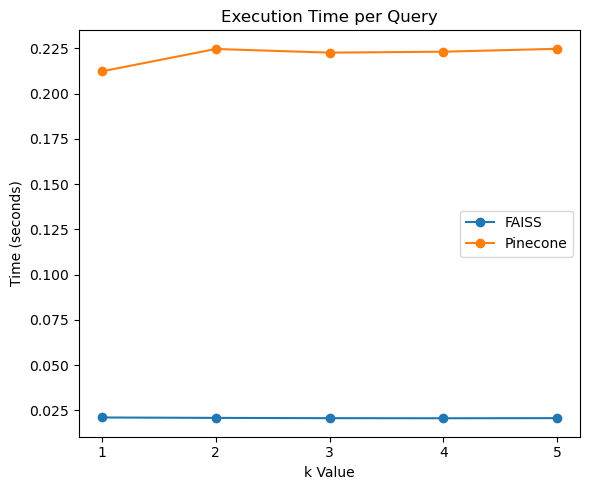

In [15]:
# Plot for Execution Time per Query
fig = plt.figure(figsize=(6, 5))
for vectorstore in vectorstores:
    plt.plot(k_values, metrics[vectorstore]['execution_time_per_query'], marker='o', label=vectorstore)
plt.title('Execution Time per Query')
plt.xlabel('k Value')
plt.ylabel('Time (seconds)')
plt.legend()
plt.xticks(k_values)
plt.tight_layout()
plt.show()
plt.savefig(fname="images/execution_time_per_query_plot.png")
plt.close()

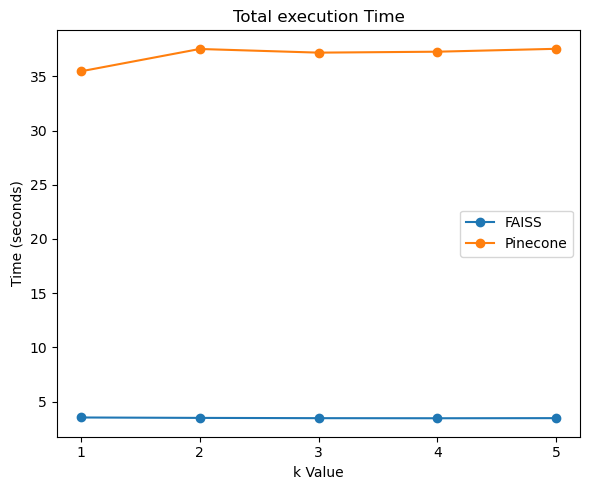

In [16]:
# Plot Total Execution Time
fig = plt.figure(figsize=(6, 5))
for vectorstore in vectorstores:
    plt.plot(k_values, metrics[vectorstore]['total_execution_time'], marker='o', label=vectorstore)
plt.title('Total execution Time')
plt.xlabel('k Value')
plt.ylabel('Time (seconds)')
plt.legend()
plt.xticks(k_values)
plt.tight_layout()
plt.show()
plt.savefig(fname="images/total_execution_time_plot.png")
plt.close()

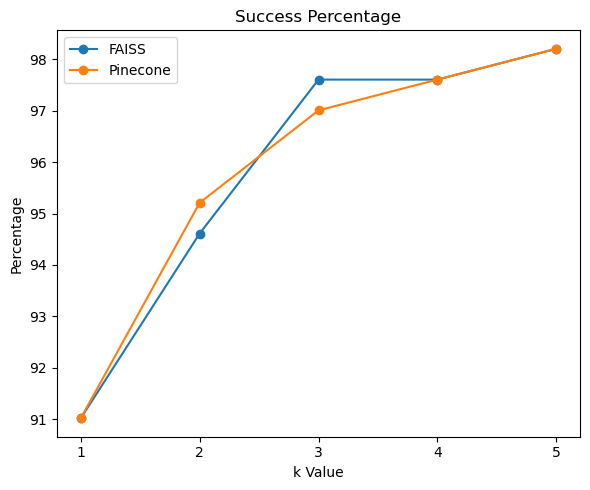

In [17]:
# Plot Success Percentage
fig = plt.figure(figsize=(6, 5))
for vectorstore in vectorstores:
    plt.plot(k_values, metrics[vectorstore]['success_percentage'], marker='o', label=vectorstore)
plt.title('Success Percentage')
plt.xlabel('k Value')
plt.ylabel('Percentage')
plt.legend()
plt.xticks(k_values)
plt.tight_layout()
plt.show()
plt.savefig(fname="images/success_percentage_plot.png")
plt.close()

In [18]:
# Generating MD file
with open('vectorstore_retrievers_evaluation.md', 'w') as md_file:
    md_file.write('# Vectorstore Retrievers Evaluation\n\n')
    md_file.write(f'This document presents the evaluation results of two vectorstore retrievers: Faiss and Pinecone, over a range of top `k` values with the search type {search_type}.\n\n')
    md_file.write('## Evaluation Results\n\n')
    md_file.write(f'The evaluation was conducted over a set of {evaluation_data.shape[0]} queries, comparing the performance based on the following metrics:\n')
    md_file.write('- Execution time per query\n')
    md_file.write('- Total execution time\n')
    md_file.write('- Match count\n')
    md_file.write('- Success percentage\n\n')

    for vectorstore, results in retrievers_eval.items():
        md_file.write(f"###  Results for {vectorstore}\n\n")
        md_file.write('| Metric | Execution Time per Query | Total Execution Time | Match Count | Success Percentage |\n')
        md_file.write('|--------|--------|-------|--------|-------|\n')
        for result in results:
            md_file.write(f"| k={result['k']} | {result['execution_time_per_query']:.4f} seconds | {result['total_execution_time']:.4f} | {result['match_count']} | {result['success_percentage']:.2%} |\n")
        md_file.write("\n")
    md_file.write('## Performance Comparison\n\n')
    md_file.write('The performance comparison between FAISS and Pinecone retrievers is visualized in the following sections.\n')
    md_file.write('### Execution Time per Query\n')
    md_file.write('![Execution Time per Query Plot](images/execution_time_per_query_plot.png)\n\n')
    md_file.write('### Total Execution Time\n')
    md_file.write('![Total Execution Time Plot](images/total_execution_time_plot.png)\n\n')
    md_file.write('### Success Percentage\n')
    md_file.write('![Success Percentage Plot](images/success_percentage_plot.png)\n\n')